In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import h5py

from hfnet.datasets.colmap_utils.read_model import read_model, qvec2rotmat
from hfnet.evaluation.utils import from_homogeneous, to_homogeneous
from hfnet.settings import DATA_PATH

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [82]:
seq = 'united_states_capitol'
base_path = Path(DATA_PATH, 'colmap')
seq_path = Path(base_path, seq)
cameras, images, points = read_model(path=Path(seq_path, 'dense/sparse').as_posix(), ext='.bin')
ids = list(images.keys())

In [83]:
def get_data(idx):
    info = images[idx]
    name = Path(info.name).stem
    K = cameras[idx].params
    K = np.array([[K[0], 0, K[2]], [0, K[1], K[3]], [0, 0, 1]])
    T = np.eye(4)
    T[:3, :3] = qvec2rotmat(info.qvec)
    T[:3, 3] = info.tvec
    image = cv2.imread(Path(seq_path, 'dense/images', info.name).as_posix())[:, :, ::-1]
    with h5py.File(Path(seq_path, 'dense/stereo/depth_maps_clean_300_th_0.10/', name+'.h5'), 'r') as f:
        depth = f['depth'].value
    valid = info.point3D_ids >= 0
    ret = {'image': image, 'depth': depth, 'name': name, 'K': K, 'T': T, 'info': info,
           'kpts': info.xys[valid], 'ids': info.point3D_ids[valid], 'valid': valid}
    return ret

<IPython.core.display.Javascript object>


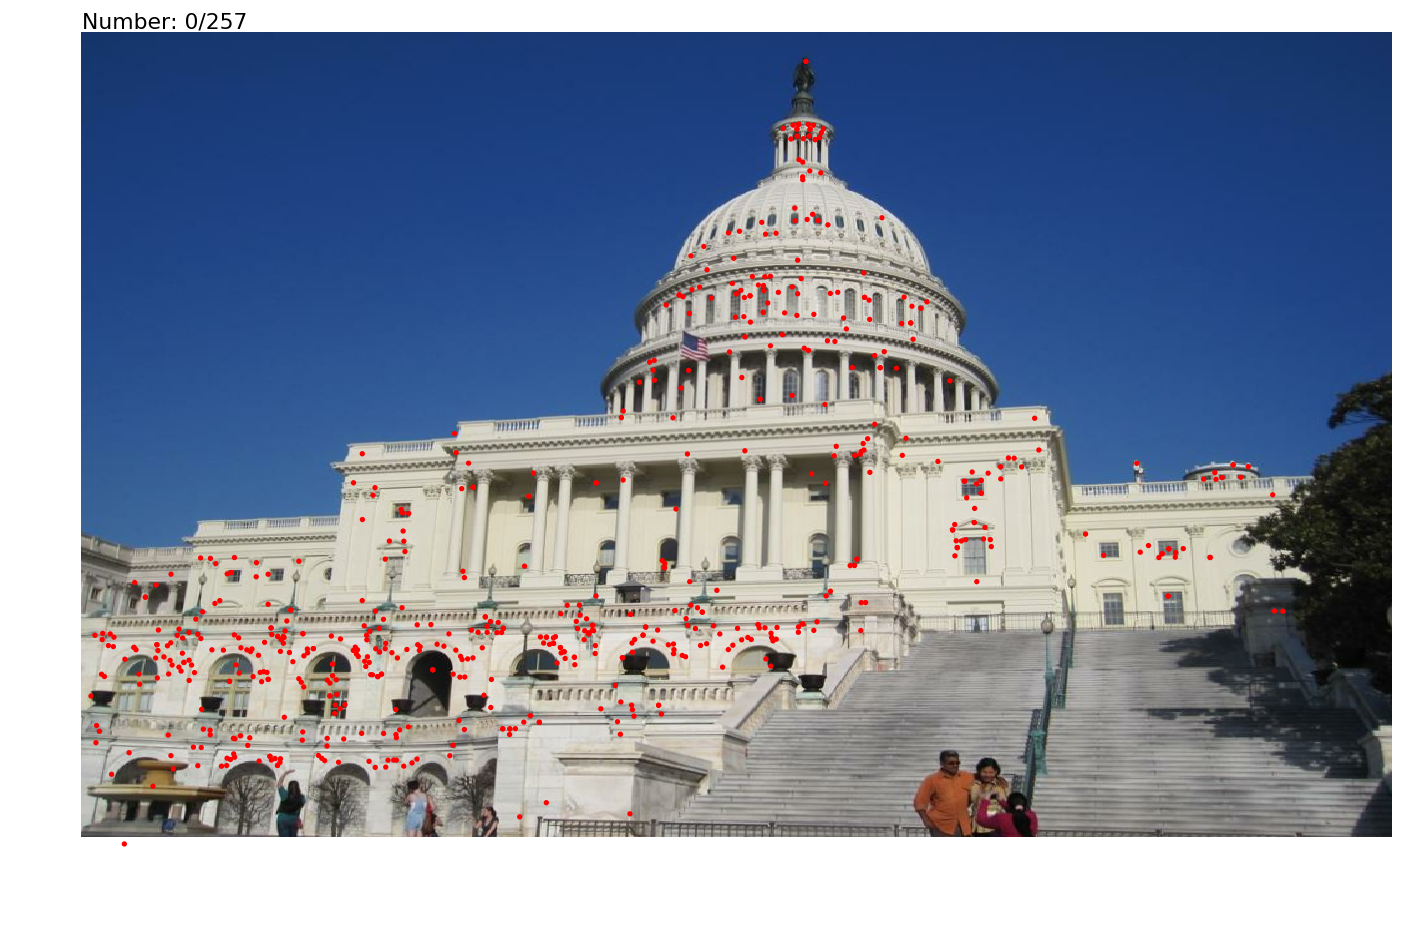

8

In [92]:
idx = -1
im, scatt, data = None, None, None
fig = plt.figure(figsize=(9, 6), dpi=100)
ax = fig.add_subplot(111)
text = ax.text(0,0, "", va="bottom", ha="left")

def draw_new():
    global im, scatt, data, idx
    idx = (idx+1) % len(ids)
    data = get_data(ids[idx])
    if im is not None:
        im.remove()
    if scatt is not None:
        scatt.remove()
    im = ax.imshow(data['image'], aspect='auto')
    scatt = ax.scatter(data['kpts'][:, 0], data['kpts'][:, 1],
                       color=["red"]*len(data['kpts']), s=[2]*len(data['kpts']), picker=4)
    text.set_text(f'Number: {idx}/{len(ids)-1}')

draw_new()
ax.axis('off')
plt.tight_layout();

saved = []
prev = None

def on_click(event):
    global prev
    ind = event.ind[-1]
    if prev is None:
        prev = ind
        scatt._facecolors[event.ind,:] = (0, 1, 0, 1)
        scatt._edgecolors[event.ind,:] = (0, 1, 0, 1)
    else:
        saved.append((data, (prev, ind)))
        draw_new()
        prev = None
    fig.canvas.draw()
    
def on_key(event):
    global prev, saved, idx
    if event.key == 'n':  # next 
        prev = None
        draw_new()
    if event.key == 'r':  # reset
        prev = None
        idx = -1
        saved = []
        draw_new()
    fig.canvas.draw()
        

fig.canvas.mpl_connect('pick_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

Instructions:
- For a given image, successively click on two points. The first one turns green once clicked.
- Skip the current image (regardless whether a first point was clicked) by pressing `n`.
- Reset the points and go back to the first image by pressing `r`.
- You might zoom in using the matplotlib's rectangle zoom feature, and zoom out by clicking on the home button.

In [ ]:
# Either use the average pairwise distance (this cell) or the distance between the centroids (next cell)
# depending on the building and the repeatability of the points
dist = []
for d, (idx1, idx2) in saved:
    pt1 = points[d['ids'][idx1]].xyz
    pt2 = points[d['ids'][idx2]].xyz
    print(pt1, pt2)
    dist.append(np.linalg.norm(pt1 - pt2))
model_dist = np.mean(dist)
print(dist, model_dist)

In [ ]:
pts = []
for d, (idx1, idx2) in saved:
    pt1 = points[d['ids'][idx1]].xyz
    pt2 = points[d['ids'][idx2]].xyz
    print(pt1, pt2)
    pts.append([pt1, pt2])
centroids = np.mean(pts, axis=0)
model_dist = np.linalg.norm(centroids[0] - centroids[1])
print(centroids, model_dist)

In [ ]:
# Enter the real distance (in meters) here, e.g. obtained from Google Maps
real_dist = 50.84
scale = real_dist/model_dist
print(f'> {seq}: {model_dist} vs {real_dist} --> scale by {scale}')

> united_states_capitol: 2.4327840150369 vs 50.84 --> scale by 20.897868321133668


> st_pauls_cathedral: 8.059038561656227 vs 55.98 --> scale by 6.9462380123536045


> sagrada_familia: 9.19853522065408 vs 38.1 --> scale by 4.141963811200239


> piazza_san_marco: 9.041552348139168 vs 77.48 --> scale by 8.569324936325351


> mount_rushmore: 4.163298513663647 vs 43.4 --> scale by 10.42442665534655


> milan_cathedral: 5.372682974434372 vs 66.77 --> scale by 12.427682838857516


> london_bridge: 2.4390147367166843 vs 69.64 --> scale by 28.55251300930921


> florence_cathedral_side: 7.30894482997043 vs 49.78 --> scale by 6.810832638368868


> british_museum: 12.747748165150048 vs 32.08 --> scale by 2.516522885798819


> reichstag: 9.277349246901208 vs 144.4 --> scale by 15.564790777735576


In [96]:
# Write to a file
with open(Path(base_path, 'scales.txt').as_posix(), 'a') as f:
    f.write(f'{seq} {scale}\n')